# Argo Profile Data : _a North Pacific Example_

Here we plot Argo temperature anomalies over the years in a North Pacific box, where we see possible hints of `NP blob 2.0` & its origin.

_Algorithm:_

- 1. get Argo data set from `GDAC` (ftp) 
- 2. apply QC & interpolate to standard levels (`MITprof`)
- 3. collocate with climatology & uncertainty field (`MITprof`)
- 4. subtract climatology & bin average over region (this notebook)

_Data Source & Format:_

- Roemmich, et al, 2019: On the Future of Argo: A Global, Full-Depth, Multi-Disciplinary Array. Frontiers in Marine Science, 6. https://doi.org/10.3389/fmars.2019.00439
- Forget, G., J.-M. Campin, P. Heimbach, C. N. Hill, R. M. Ponte, and C. Wunsch, 2015: ECCO version 4: an integrated framework for non-linear inverse modeling and global ocean state estimation. Geoscientific Model Development, 8, 3071-3104, <https://doi.org/10.5194/gmd-8-3071-2015>


## Set up tools


In [1]:
using ArgoData, Plots, MAT, Dates, Statistics
argo_T = matread("argo_T.mat")
argo_S = matread("argo_S.mat")

Dict{String,Any} with 13 entries:
  "prof_YYYYMMDD" => [2.00701e7; 2.00701e7; … ; 2.01912e7; 2.01912e7]
  "prof_lat"      => [41.392; 42.631; … ; 27.758; 24.536]
  "prof"          => [33.8358 33.8359 … 34.5735 NaN; 33.133 33.133 … 34.5765 Na…
  "nd"            => 272.0
  "prof_descr"    => Any["4900650"; "4900655"; … ; "4901659"; "5906156"]
  "np"            => 15871.0
  "prof_depth"    => [5.0; 15.0; … ; 1900.0; 2000.0]
  "monclim"       => [33.5694 33.5713 … 34.5743 NaN; 33.1677 33.1721 … 34.5747 …
  "nr"            => 55.0
  "prof_lon"      => [-159.846; -156.544; … ; -156.94; -157.699]
  "list_descr"    => Any["1901379"; "29000"; … ; "6900680"; "6900681"]
  "prof_HHMMSS"   => [82626.0; 140154.0; … ; 101513.0; 90334.0]
  "prof_date"     => [7.33043e5; 7.33044e5; … ; 7.3779e5; 7.3779e5]

## Compute Depth-Time Anomalies

In [2]:
years=collect(2006:2019); ny=length(years); nd=Int(argo_T["nr"])
tim=[y+m/12 for m in 1:12, y in years][:]
dep=-argo_T["prof_depth"]


δt=Millisecond(86400. *1000. *30.) # 30 for +/-30 days in miliseconds
δl=5 # 5 for +/-5 degree ranges
argo_time = julian2datetime.( datetime2julian(DateTime(0)) .+ argo_T["prof_date"] )

function TimeDepthMedian(x,λ=40.)
    anom=Array{Float64,2}(undef,ny*12,nd)
    for y=1:ny, m=1:12, d=1:nd
        tt=findall( (abs.(argo_time.-DateTime(years[y],m,15)).<δt) .&
                    (abs.(argo_T["prof_lat"].-λ).<δl) )
        tt=[tt[i][1] for i in 1:length(tt)]
        xx=(x)[tt,d]
        xx=xx[findall((!isnan).(xx))]
        ~isempty(xx) ? xm=median(xx) : xm=NaN
        anom[m+(y-1)*12,d]=xm
    end

    return anom,λ
end

TimeDepthMedian (generic function with 2 methods)

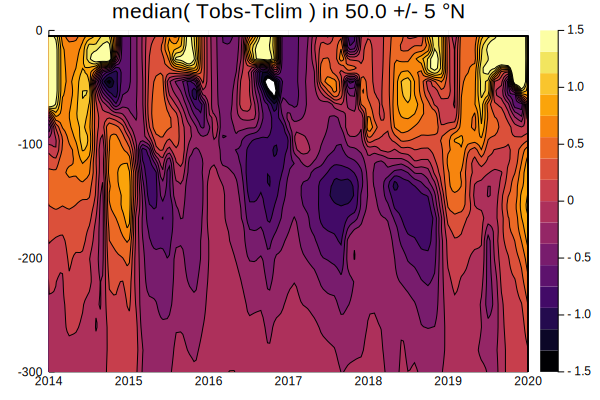

In [3]:
anom,λ=TimeDepthMedian(argo_T["prof"]-argo_T["monclim"],50.); v="Tobs-Tclim"
contourf(tim,vec(dep)[end:-1:1],transpose(anom[:,end:-1:1]),title="median( $v ) in $λ +/- $δl °N",xlim=(2014.,2020.),ylim=(-300.,0.),clim=(-1.5,1.5))

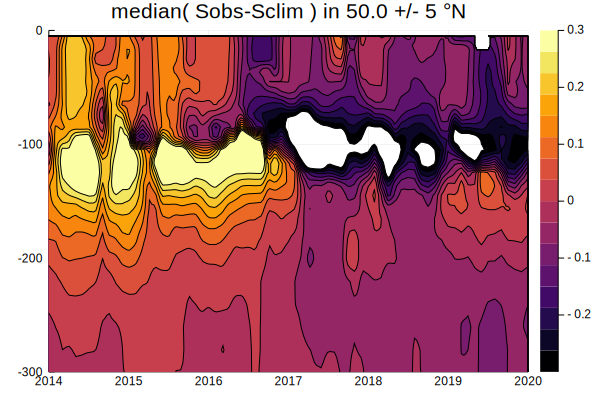

In [4]:
anom,λ=TimeDepthMedian(argo_S["prof"]-argo_S["monclim"],50.); v="Sobs-Sclim"
contourf(tim,vec(dep)[end:-1:1],transpose(anom[:,end:-1:1]),title="median( $v ) in $λ +/- $δl °N",xlim=(2014.,2020.),ylim=(-300.,0.),clim=(-0.3,0.3))